# Exploration of the .skeleton files provided in the NTU-RGB-D dataset

In [1]:
import numpy as np
import os
from joints import *

In [2]:
# Code courtesy of yysijie and the awesome paper ST-GCN
# https://github.com/yysijie/st-gcn/
def read_skeleton(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []
        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []
            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)
    return skeleton_sequence


def read_xyz(file, max_body=2, num_joint=25):
    seq_info = read_skeleton(file)
    data = np.zeros((3, seq_info['numFrame'], num_joint, max_body))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[:, n, j, m] = [v['x'], v['y'], v['z']]
                else:
                    pass
    return data

def read_color_xy(file, max_body=2, num_joint=25):
    seq_info = read_skeleton(file)
    data = np.zeros((2, seq_info['numFrame'], num_joint, max_body))
    
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[:, n, j, m] = [v['colorX'], v['colorY']]
                else:
                    pass
    return data

## Skeleton numpy array

read_xyz(...) returns a (3, max_frame, num_joint=25, 2) numpy array

read_color_xy(...) returns (2, max_frame, num_joint=25, 2) numpy array

In [3]:
skeleton = read_xyz("./S001C001P001R001A001.skeleton") # shape (3, 103, 25, 2)

print("===== 3D skeleton =====")
print(skeleton[:, 0, :, 0])
print(skeleton.transpose(3, 2, 0, 1)[0].shape)

print("\r\n===== 2D RGB skeleton =====")
skeleton_2d = read_color_xy("./S001C001P001R001A001.skeleton")
print(skeleton_2d[:, 0, :, 0])

===== 3D skeleton =====
[[ 0.2181153   0.2323292   0.2457799   0.2128507   0.1109304   0.100875
   0.1186992   0.1165352   0.3449145   0.4211396   0.1918999   0.1298675
   0.162766    0.1975115   0.2442706   0.2040377   0.2699234   0.3105748
   0.3428889   0.2951482   0.2425592   0.1200176   0.0989792   0.08710064
   0.1268453 ]
 [ 0.1725972   0.4326636   0.6877249   0.8079225   0.6111551   0.4286715
   0.3428923   0.3173672   0.5740387   0.3847547   0.3189077   0.317039
   0.1745395  -0.1360554  -0.4201995  -0.476396    0.1678491  -0.1462299
  -0.433214   -0.5017325   0.6247278   0.2955468   0.3459614   0.2988889
   0.2813963 ]
 [ 3.785547    3.714767    3.633897    3.581995    3.716962    3.742593
   3.556542    3.550741    3.588655    3.627778    3.540756    3.542577
   3.778471    3.904381    4.054147    4.094294    3.730005    3.818383
   3.943258    3.968896    3.656055    3.532409    3.527539    3.54619
   3.549525  ]]
(25, 3, 103)

===== 2D RGB skeleton =====
[[1036.233  1041.9

## Skeleton animation

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time
import mpl_toolkits.mplot3d as plt3d

def animateJointCoordinates(joint_coordinates, connexion_tuples):
    '''
    joint_coordinates : shape(joints, 3, seq_len)
    
    
    '''
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = plt.axes(projection='3d')
    
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    x = 0
    y = 2
    z = 1

    
    for t in range(joint_coordinates.shape[2]):
        ax.clear()
        ax.set_xlim3d(np.amin(joint_coordinates[:, x, :]), np.amax(joint_coordinates[:, x, :]))
        ax.set_ylim3d(np.amin(joint_coordinates[:, y, :]), np.amax(joint_coordinates[:, y, :]))
        ax.set_zlim3d(np.amin(joint_coordinates[:, z, :]), np.amax(joint_coordinates[:, z, :]))
        
        ax.scatter(joint_coordinates[:, x, t], joint_coordinates[:, y, t], joint_coordinates[:, z, t])
        
        
        line = plt3d.art3d.Line3D([0.1, 0.1], [0.1, 0.5], [0.1, 0.1])
        
        head_neck = plt3d.art3d.Line3D([joint_coordinates[0, x, t], joint_coordinates[1, x, t]], 
                                      [joint_coordinates[0, y, t], joint_coordinates[1, y, t]], 
                                      [joint_coordinates[0, z, t], joint_coordinates[1, z, t]])
        
        # ax.add_line(head_neck)
        
        for i in range(connexion_tuples.shape[0]):
            j1 = connexion_tuples[i, 0]
            j2 = connexion_tuples[i, 1]
            
            
            joint_line = plt3d.art3d.Line3D([joint_coordinates[j1, x, t], joint_coordinates[j2, x, t]], 
                                            [joint_coordinates[j1, y, t], joint_coordinates[j2, y, t]], 
                                            [joint_coordinates[j1, z, t], joint_coordinates[j2, z, t]])
            
            ax.add_line(joint_line)
        
        ax.view_init(10, 10)
        
        fig.canvas.draw()
        plt.pause(.001)
        # time.sleep(0.01)

In [5]:
# animateJointCoordinates(skeleton.transpose(3, 2, 0, 1)[0], connexion_tuples)

## Video playback

Creates a video object of size (seq_len, 1080, 1920, 3)

In [6]:
import ffmpeg
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.patches import Circle



In [7]:
probe = ffmpeg.probe('./S001C001P001R001A001_rgb.avi')
video_info = next(x for x in probe['streams'] if x['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])
print(num_frames)

103


In [8]:
out, err = (ffmpeg
           .input('./S001C001P001R001A001_rgb.avi')
           .output('pipe:', format='rawvideo', pix_fmt='rgb24')
           .run(capture_stdout=True)
)
video = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])
print(video.shape)

(103, 1080, 1920, 3)


<IPython.core.display.Javascript object>


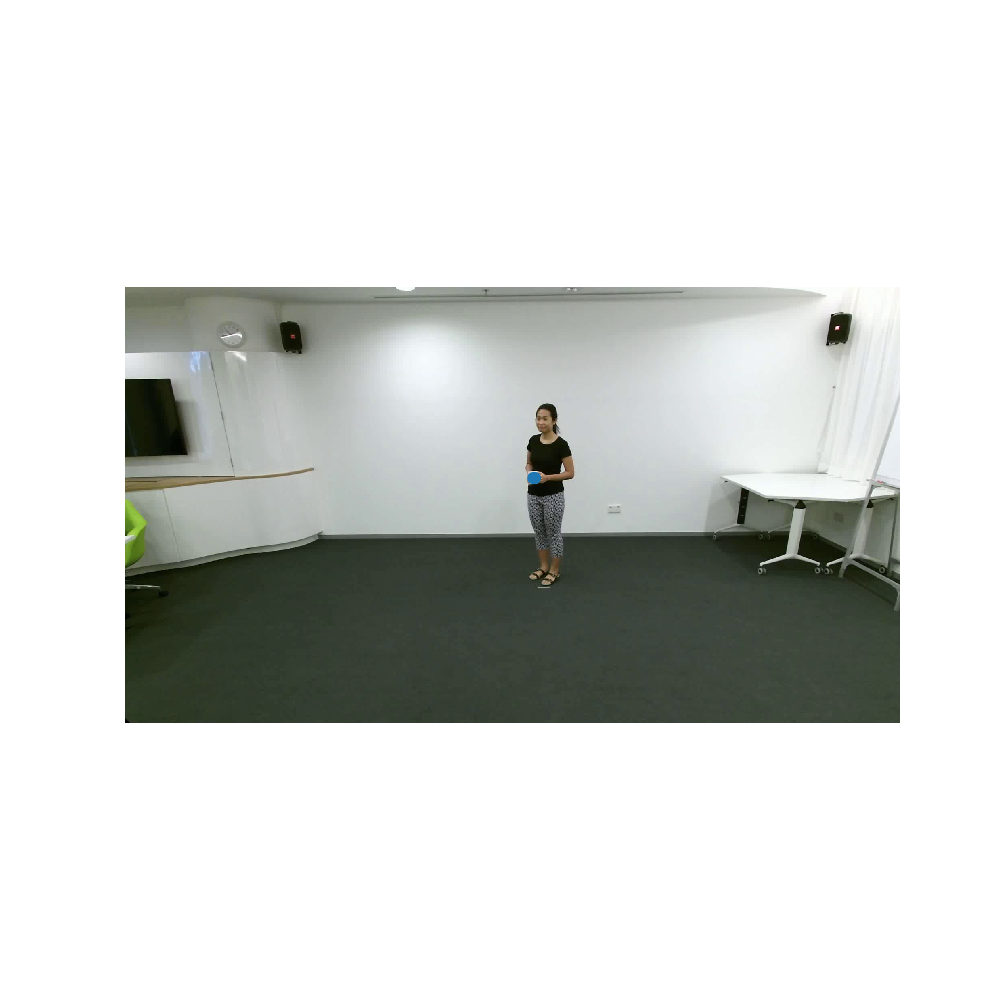

In [9]:
f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

image = plt.imshow(video[0], interpolation='None', animated = True)
right_hand = Circle((skeleton_2d[0, 0, Joints.HANDRIGHT, 0], skeleton_2d[1, 0, Joints.HANDRIGHT, 0]),15)
left_hand = Circle((skeleton_2d[0, 0, Joints.HANDLEFT, 0], skeleton_2d[1, 0, Joints.HANDLEFT, 0]),15)

ax.add_patch(right_hand)
ax.add_patch(left_hand)

plt.axis('off')


def videoAnimation(frame_index):
    image.set_data(video[frame_index])
    [p.remove() for p in ax.patches]
    right_hand = Circle((skeleton_2d[0, frame_index, Joints.HANDRIGHT, 0], skeleton_2d[1, frame_index, Joints.HANDRIGHT, 0]),15)
    left_hand = Circle((skeleton_2d[0, frame_index, Joints.HANDLEFT, 0], skeleton_2d[1, frame_index, Joints.HANDLEFT, 0]),15)
    
    ax.add_patch(right_hand)
    ax.add_patch(left_hand)
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 33, frames = num_frames, repeat = False)


## Crop around the hands

According to "Pose-conditioned Spatio-Temporal Attention for Human Action Recognition" https://arxiv.org/pdf/1703.10106.pdf, the crops are 50x50p around hands on NTU dataset. The same cropping dimensions are kept on latter paper STA-Hands by same author.


<IPython.core.display.Javascript object>


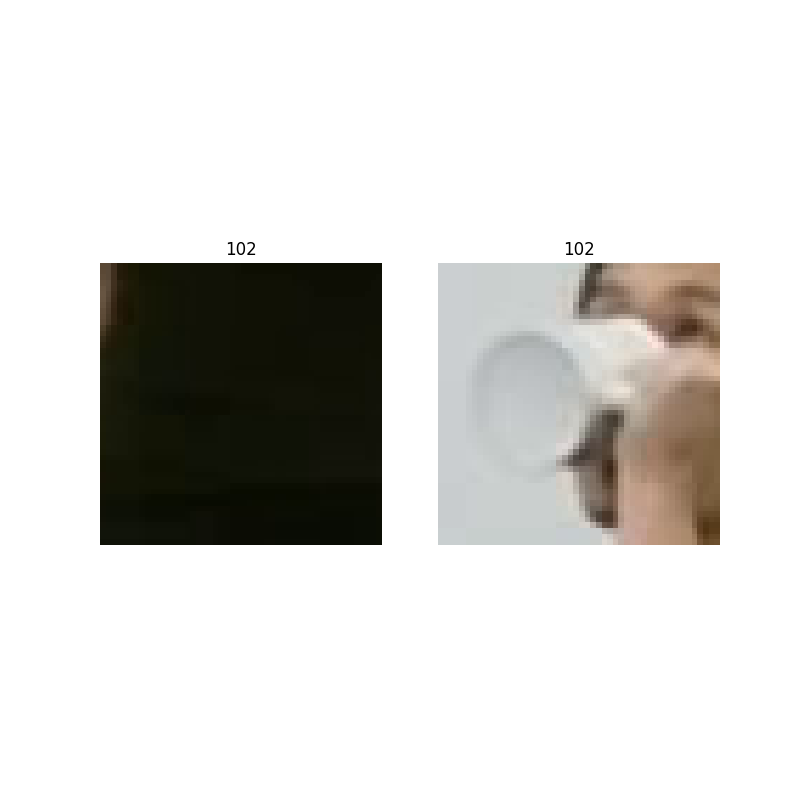

In [14]:
# Using video for variable from above of shape (seq_len, 1080, 1920, 3)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(8, 8)
ax1.axis('off')
ax2.axis('off')

left_hand_x = int(skeleton_2d[1, 0, Joints.HANDLEFT, 0])
left_hand_y = int(skeleton_2d[0, 0, Joints.HANDLEFT, 0])
left_hand_crop = video[0, left_hand_x-25:left_hand_x+25, left_hand_y-25:left_hand_y+25, :]
left_hand_crop_plot = ax1.imshow(left_hand_crop)

right_hand_x = int(skeleton_2d[1, 0, Joints.HANDRIGHT, 0])
right_hand_y = int(skeleton_2d[0, 0, Joints.HANDRIGHT, 0])
right_hand_crop = video[0, right_hand_x-25:right_hand_x+25, right_hand_y-25:right_hand_y+25, :]
right_hand_crop_plot = ax2.imshow(right_hand_crop)


def videoAnimation(frame_index):
    left_hand_x = int(skeleton_2d[1, frame_index, Joints.HANDLEFT, 0])
    left_hand_y = int(skeleton_2d[0, frame_index, Joints.HANDLEFT, 0])
    left_hand_crop = video[frame_index, left_hand_x-25:left_hand_x+25, left_hand_y-25:left_hand_y+25, :]
    left_hand_crop_plot.set_data(left_hand_crop)
    ax1.set_title(frame_index)
    
    right_hand_x = int(skeleton_2d[1, frame_index, Joints.HANDRIGHT, 0])
    right_hand_y = int(skeleton_2d[0, frame_index, Joints.HANDRIGHT, 0])
    right_hand_crop = video[frame_index, right_hand_x-25:right_hand_x+25, right_hand_y-25:right_hand_y+25, :]
    right_hand_crop_plot.set_data(right_hand_crop)
    ax2.set_title(frame_index)
    
    
    return left_hand_crop_plot, right_hand_crop_plot

ani = animation.FuncAnimation(f, videoAnimation, interval = 33, frames = num_frames, repeat = False)

